In [2]:
import numpy as np
from scipy.linalg import eigh
from scipy.optimize import minimize
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [3]:
class MyKernel:
    
    def __init__(self, theta, bounds=None):
        self.theta = theta
        self.bounds = bounds
        
    def __call__(self, X, Y, eval_gradient=False):
        '''
        This method calcualtes the kernel matrix for input points.
        
        Parameters
        ----------
        X, Y : 2-D numpy array
            numpy array representing input points. X[n, i] (resp. Y[n, i]) represents the i-th element of n-th point in X (resp Y).
        eval_gradientt : bool
            If True, the gradient of the kernel matrix w.r.t. to parameters are also returned.
            
        Returns
        ----------
        K : 2-D numpy array, shape = (len(X), len(Y))
            numpy array representing the kernel matrix. K[i, j] stands for k(X[i], Y[j])
        gradK : 3-D numpy array, shape = (len(self.theta), len(X), len(Y)), optional
            numpy array representing the gradient of kernel matrix. gradK[l, m, n] = derivative of K[m, n] w.r.t. self.theta[l]
            Returned only if return_std is True.
        '''
            
        tmp = np.reshape(np.sum(X**2,axis=1), (len(X), 1)) + np.sum(Y**2, axis=1)  -2 * (X @ Y.T)
        K = self.theta[0]*np.exp(-self.theta[1]/2*tmp) + self.theta[2] + self.theta[3]*(X @ Y.T)
        
        if not(eval_gradient):
            return K
        else:
            gradK = np.zeros((len(self.theta), len(X), len(Y)))
            gradK[0] = np.exp(-self.theta[1]/2*tmp)
            gradK[1] = -self.theta[0]/2*tmp*np.exp(-self.theta[1]/2*tmp)
            gradK[2] = np.ones((len(X), len(Y)))
            gradK[3] = X @ Y.T
            return K, gradK
        
    def diag(self, X):
        '''
        This method calculates the diagonal elements of the kernel matrix.
        
        Parameters
        ----------
        X : 2-D numpy array
            numpy array representing input points. X[n, i] represents the i-th element of n-th point in X.
        
        Returns
        ----------
        diagK : 1-D numpy array
            numpy array representing the diagonal elements of the kernel matrix. diagK[n] = K[n, n]
        '''
        diagK = self.theta[0] + self.theta[2] + self.theta[3]*np.sum(X**2, axis=1) 
        return diagK

In [4]:
def cost_and_grad(beta, theta, kernel, X, t, return_grad=False):
    '''
    The method calculates cost function (negative of log marginal likelihood) and its gradient
    
    Parameters
    ----------
    beta : float
        noise parameter (precision)
    theta : 1-D numpy array
        1-D numpy array representing kernel parameteres
    kernel : kernel object
        An object representing kernel function
    X : 2-D numpy array
        Array representing input data, with X[n, i] being the i-th element of n-th point in X.
    t : 1-D numpy array
        Array representing label data.
    return_grad : bool
        If True, the function also returns the gradient of the cost function.
        
    Returns
    ----------
    val : float
        The value of the cost function
    grad : 1-D numpy array, optional
        Array representing the gradient of the cost function. Returned only if return_grad is True.
    '''
    kernel.theta = theta
    K, gradK = kernel(X, X, eval_gradient=True)
    C = K + 1.0/beta*np.identity(len(K))
    Cinv = np.linalg.inv(C)
    val = np.sum(np.log(eigh(C)[0])) + 0.5 * t @ Cinv @ t + 0.5*len(X)*np.log(2*np.pi)
    if not(return_grad):
        return val
    else:
        grad = np.zeros(len(theta)+1)
        grad[0] = -0.5*np.trace(Cinv)/(beta**2) + 0.5/(beta**2) * (t @ Cinv @ Cinv @ t)
        for cnt in range(len(theta)):
            grad[cnt+1] = 0.5 * np.trace(Cinv @ gradK[cnt]) - 0.5 * t @ Cinv @ gradK[cnt] @ Cinv @ t
        return val, grad

In [6]:
class GPRegression:
    
    def __init__(self, kernel, beta):
        self.kernel = kernel
        self.beta = beta
        
    def fit(self, X, t, optimize_hparams=False):
        '''
        Parameters
        ----------
        X : 2-D numpy array
            Array representing training input data, with X[n, i] being the i-th element of n-th point in X.
        t : 1-D numpy array
            Array representing training label data.
        optimize_hparams : bool
            If True, optimization of hyperparameters (noise parameter and kernel parameters) is performed.
        '''
        self.X_train = X
        self.t_train = t
        if optimize_hparams:
            theta_old = np.copy(self.kernel.theta)
            bounds_full = np.concatenate(( [[0, None]], self.kernel.bounds ), axis=0)
            result = minimize(x0=np.append([self.beta], [self.kernel.theta]),
                              fun=lambda x : cost_and_grad(beta=x[0], theta=x[1:], kernel=self.kernel, X=self.X_train, t=self.t_train, return_grad=True), 
                              jac=True,
                              bounds=bounds_full)
            if not(result.success):
                print(result.message)
                self.kernel.theta = theta_old
            else:
                print(result.message)
                self.beta = result.x[0]
                self.kernel.theta = result.x[1:]
        self.Cinv = np.linalg.inv( self.kernel(self.X_train, self.X_train) + 1.0/self.beta*np.identity(len(self.X_train)) )
        
    def predict(self, X, return_std=False):
        '''       
        Parameters
        ----------
        X : 2-D numpy array
            Array representing test input data, with X[n, i] being the i-th element of n-th point in X.
        return_std : bool
            If True, predictive standard deviation is also returned.
        
        Returns
        ----------
        mean : 1-D numpy array
            Array representing predictive mean.
        std : 1-D numpy array, optional
            Array reprensenting predictive standard deviation, returned only if return_std is True.
        '''
        kappa = self.kernel(X, self.X_train)
        mean = kappa @ (self.Cinv @ self.t_train)
        if not(return_std):
            return mean
        else:
            std = np.sqrt( self.kernel.diag(X) + 1.0/self.beta - np.diag( kappa @ self.Cinv @ (kappa.T) ) )
            return mean, std

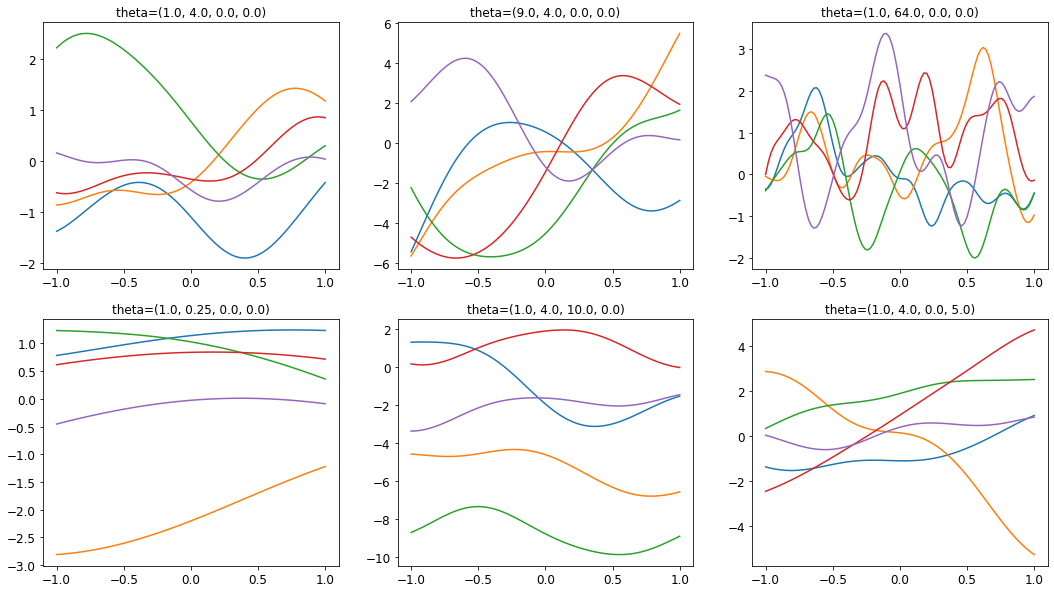

In [7]:
X = np.linspace(-1,1,101)
X = np.reshape(X, (len(X),-1))
Thts = np.array([[1.0, 4.0, 0.0, 0.0],
                 [9.0, 4.0, 0.0, 0.0],
                 [1.0, 64.0, 0.0,0.0],
                 [1.0,0.25, 0.0, 0.0],
                 [1.0, 4.0, 10.0, 0.0],
                 [1.0, 4.0, 0.0, 5.0]
                ])

num  = 5
cnt = 0
fig = plt.figure(figsize=(18,10))
while cnt < len(Thts):
    theta = Thts[cnt]
    kernel = MyKernel(theta)
    Kmat = kernel(X, X)
    yy = np.random.multivariate_normal(np.zeros(len(X)), Kmat, num)
    ax = fig.add_subplot(2,3,cnt+1)
    for y in yy:
        ax.plot(X, y)
    ax.set_title(f"theta=({theta[0]}, {theta[1]}, {theta[2]}, {theta[3]})")
    cnt += 1

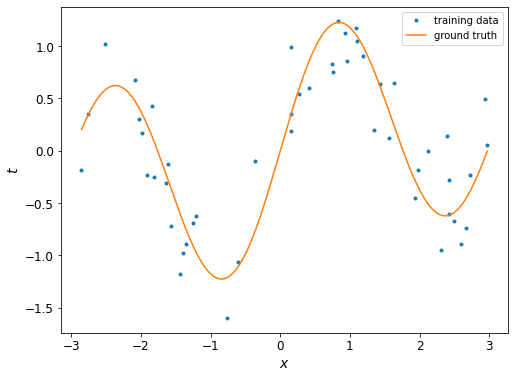

In [8]:
def truef(x):
    return np.sin(2*x)  + 0.2*np.sin(x) + 0.1*x

N = 50
X = np.random.uniform(-3, 3, N)
ep = 0.3*np.random.randn(N)
t = truef(X) + ep

Xcont = np.linspace(np.min(X),np.max(X),200) # for plotting

plt.figure(figsize=(8,6))
plt.plot(X, t,'.', label='training data')
plt.plot(Xcont, truef(Xcont), label='ground truth')
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.legend()
plt.show()

X = np.reshape(X,(len(X),1))
Xtest = np.reshape(Xcont,(len(Xcont),1))

In [9]:
def plot_result(pred_mean, pred_std, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111)
    ax.plot(X, t,'.',label='training data')
    ax.plot(Xcont, pred_mean, label='predictive mean')
    ax.plot(Xcont, truef(Xcont), ':', label='ground truth')
    ax.fill_between(Xcont, pred_mean + pred_std, pred_mean - pred_std, alpha=0.2)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$t$')
    ax.legend()

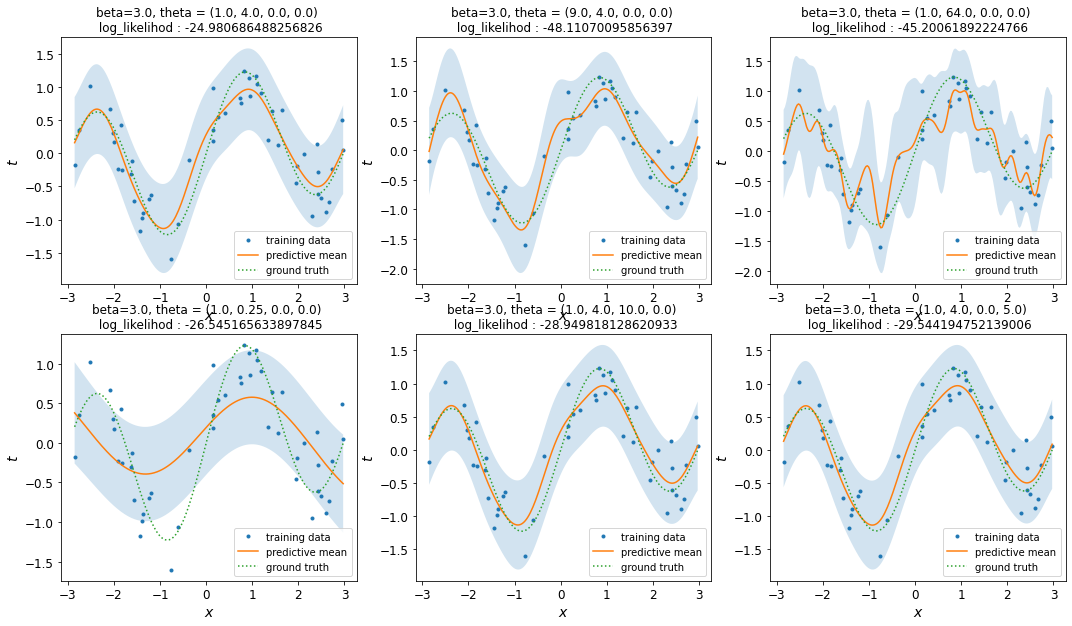

In [10]:
Thts = np.array([[1.0, 4.0, 0.0, 0.0],
                 [9.0, 4.0, 0.0, 0.0],
                 [1.0, 64.0, 0.0,0.0],
                 [1.0,0.25, 0.0, 0.0],
                 [1.0, 4.0, 10.0, 0.0],
                 [1.0, 4.0, 0.0, 5.0]
                ])

beta = 3.0

kernel = MyKernel(theta = np.array([0.0, 0.0, 0.0, 0.0]), bounds=[[0.0, None],[0.0, None],[0.0, None],[0.0, None]])
gpr = GPRegression(kernel=kernel, beta=beta)

fig = plt.figure(figsize=(18,10))
cnt = 0
while cnt < len(Thts):
    theta = Thts[cnt]
    kernel.theta = theta
    gpr.fit(X, t)
    mean, std = gpr.predict(Xtest, return_std=True)
    ax = fig.add_subplot(2, 3, cnt+1)
    plot_result(mean, std, ax)
    ax.set_title(f"beta={gpr.beta}, theta = ({theta[0]}, {theta[1]}, {theta[2]}, {theta[3]}) \n log_likelihod : {-cost_and_grad(beta=gpr.beta, theta=gpr.kernel.theta, kernel=gpr.kernel, X=X, t=t, return_grad=False)}")
    cnt += 1
plt.show()

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
beta = 7.833816451778429
theta=[0.31619789 1.97451354 0.         0.        ]
log_likelihod : 12.594636200256275


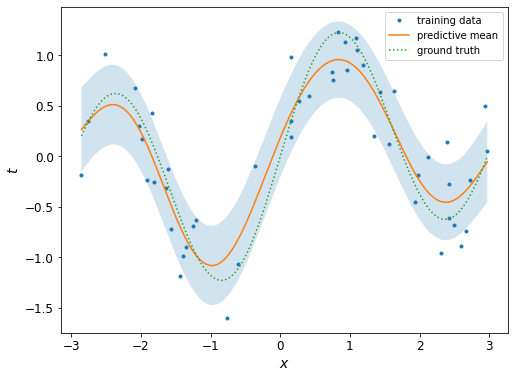

In [11]:
kernel = MyKernel(theta = np.array([2.0, 1.0, 0.01, 0.02]), bounds=[[0.0, None],[0.0, None],[0.0, None],[0.0, None]])
gpr = GPRegression(kernel=kernel, beta=1.0)
gpr.fit(X, t, optimize_hparams=True)
mean, std = gpr.predict(Xtest, return_std=True)
print(f"beta = {gpr.beta}")
print(f"theta={kernel.theta}")
print(f"log_likelihod : {-cost_and_grad(beta=gpr.beta, theta=gpr.kernel.theta, kernel=gpr.kernel, X=X, t=t, return_grad=False)}")
plot_result(mean, std)

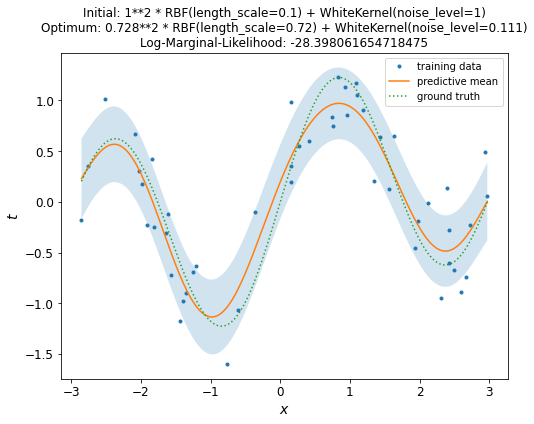

In [12]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

kernel = 1.0 * RBF(length_scale=0.1, length_scale_bounds=(1e-3, 1e2)) \
    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 3e+1))
gp = GaussianProcessRegressor(kernel=kernel,alpha=0.0)

# fitting 
gp.fit(X, t)

# prediction
y_mean, y_std = gp.predict(Xtest, return_std=True)

# plotting
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
plot_result(y_mean, y_std, ax)
ax.set_title(f"Initial: {kernel}\n\
Optimum: {gp.kernel_}\n\
Log-Marginal-Likelihood: {gp.log_marginal_likelihood(gp.kernel_.theta)}")
plt.show()